<a href="https://colab.research.google.com/github/courtneytumolac/Data-Science/blob/main/CourTumoU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-s4cqsepe
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-s4cqsepe
  Resolved https://github.com/pydata/xarray.git to commit 7551a7a4fcad82a27b3701cfa0af85f74404a45c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.4.1.dev19+g7551a7a4-py3-none-any.whl size=1304219 sha256=fbf3f210d15132544c2d590d66cc7214a3fd0505f1f7f17fa4fef5b0c808d4f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ubb_i9il/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalled xarray-2025.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 1.2 MB/s eta 0:00:00
   ━

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

In [ ]:
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
import preliz as pz
import pymc as pm
import numpy as np

In [ ]:
#load the data into a pandas dataframe, and print it
url_soccer = 'https://raw.githubusercontent.com/courtneytumolac/Data-Science/refs/heads/main/japan_soccer.csv'
#I could have put the url string directly into pd.read_csv()
soccer = pd.read_csv(url_soccer)

In [ ]:
soccer.head()

,Number,Player,Position,Age (today),Appearances,Assists,Penalty kicks,Minutes played,Minutes per goal,Goals per match,Goals
0,1,Masatoshi Matsuda,Centre-Forward,33 (44),171,27,12,13.318',157',0.50,85
1,2,Yuta Uchino,Centre-Forward,30 (33),217,26,1,13.463',184',0.34,73
2,3,Gen Nakamura,Attacking Midfield,36 (44),244,50,18,20.084',283',0.29,71
3,4,Koji Ishihara,Centre-Forward,32,258,33,10,19.243',271',0.28,71
4,5,Jun Arima,Centre-Forward,27 (32),133,15,13,10.468',156',0.50,67


In [ ]:
#convert from pandas to numpy array
assists = soccer["Assists"].values
appearances = soccer["Appearances"].values[:,None]

In [ ]:
#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [ ]:
with pm.Model() as model_hsgp:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(appearances))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=appearances)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=assists)

    idata_hsgp = pm.sample()

Output()

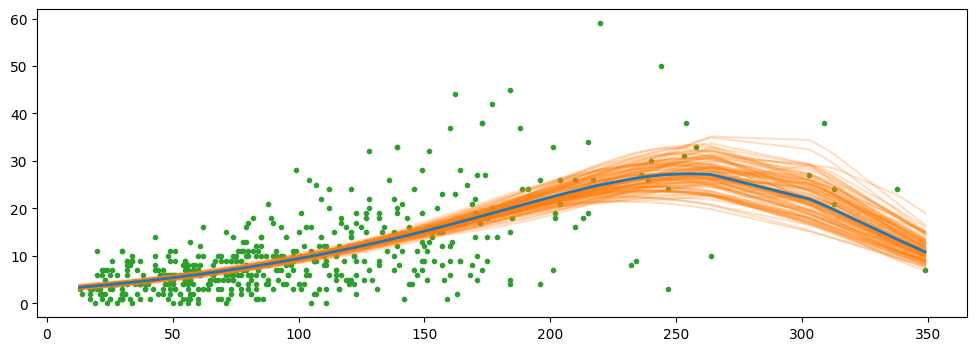

In [ ]:
#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(soccer["Appearances"].values, soccer["Assists"].values, "C2.")

#grab posterior
f = az.extract(idata_hsgp, group="posterior", var_names="f")


idx = np.argsort(soccer["Appearances"].values)
#plot samples of the posterior
ax.plot(soccer["Appearances"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
#plot posterior mean
ax.plot(soccer["Appearances"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)